# Predicting Federal Funds Rate Change
    Xander de la Bruere
    Jakob Gertsch
    Sam Layton
    Matt Mella
    Wilson Stoddard

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prince import FAMD
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
from sklearn import linear_model

### Research Question Overview

One of the most important economic outcomes of the United States is the federal funds rate, commonly referred to as the interest rate. The federal funds rate is a target interest rate set by the Federal Reserve in an attempt to control other key economic indicators, such as inflation and unemployment rate. The Federal Reserve moves the prevailing interest rate towards its target interest rate by setting a discount rate (the cost banks face to borrow money from other banks in order to meet overnight reserve requirements), engaging in open market operations (reducing or increasing the quantity of U.S. treasury bills available for purchase), and adjusting the reserve requirement (the percentage of money banks must keep in reserve rather than lending it to clients) [1].

Significantly, an increase or decrease in the federal funds rate impacts levels of personal consumption and spending as well as corporate investment (higher interest rates increase cost to companies of borrowing money). For example, when interest rates are relaively high, consumers have higher incentive to save money (and get interest) rather than spending, and companies have lower incentive to invest (since they must borrow money at a high interest rate to do so), leading to the economy cooling off as a whole. Conversely, lower interest rates increase personal consumption and corporate investment, leading to the economy heating up as a whole. Cumulatively, these personal and corporate decisions, all based on the federal funds rate, have direct and dramatic effects on important economic indicators such as inflation, real GDP, mortgage prices, and unemployment.

Since the federal funds rate influences so many economic outcomes, foreknowledge of changes in the federal funds rate would allow strategic economic decision-making and investment that would allow for both individuals and corporations to maximize earnings and to minimize or eliminate potential losses. For this reason, much effort has been exerted to predict changes in the target federal funds rate announced periodically by the Federal Open Market Committee (FOMC), the policy-making team of the Federal Reserve [2]. The FOMC has shared some indicators that it considers in its decisions, including various price indices and labor market indicators [3], but it does not explicitly reveal its goals or the way these metrics are weighted or used in its decision making process.

Many predictive bodies, such as the Blue Chip consensus, are relatively successful at predicing changes in the federal funds rate when most or all economic indicators are optimal (or terrible), but are less sucessful when economic conditions are mixed [4]. Using the techniques of logistic regression and classification, we seek to build upon the methods of these predictive bodies by developing a robust model for predicting changes in the target federal funds rate based on publically available economic indicators. In doing so, we will focus on predicting which of three outcomes will occur on the day of a given FOMC policy announcement: 1) a positive change in the federal funds rate, 2) a negative change in the federal funds rate, and 3) no change in the federal funds rate. In particular, we seek to 1) explore what model is the most effective at predicting these outcomes, 2) determine which features are most important in predicting these outcomes, and 3) determine how well these outcomes can be predicted using machine learning algorithms.


### Our Data

In our search for data on key economic indicators that might influence the federal funds rate, we looked to the St. Louis Federal Reserve (FRED) website. This site hosts an enormous amount of time series data on economic indicators that have been tracked carefully and methodically for years. In selecting features, we focused on features with data continuously tracked since 1989 (the first year for which FOMC federal funds rate decisions are available) to the present day. We also chose features that we felt were most likely to have predictive power in determining the FOMC's decision to raise or lower interest rate. With these two considerations in mind, we selected the prime loan interst rate, exports, personal consumption, unemployment rate, GDP, vehicle sales, cash flows, housing starts, and a composite indicator, as well as a categorical variable for recession.

In addition, since we hypothesized that stock market values and the strength of the dollar might be important factors in the FOMC's decision, we took daily reports of the S&P 500 closing price and US Dollar index for the relevant time period (as reported on Yahoo Finance) and appended these features to our dataset. We also generated categorical features for political party of the Fed chair and political party of the U.S. president.

Finally, our search for data on the dependent variables of interest--the federal funds rate, its percentage point change at each announcement, and the direction of change--led us to a dataset provided by Dr. Kuttner, professor of economics at Williams University, containing recorded values of these variables from 1989 to 2019. We built upon this dataset, using FOMC announcement archives from 2019 to the present to complete the set.

### Data Cleaning

The datasets we obtained were well-maintained, containing no missing data or invalid values. However, our data did not agree in frequency. For example, some variables inclduing GDP and exports are reported quarterly, while others such as consumer expenditures and composite leading indicators are reported monthly. Further, a couple features (stock closign price and dollar index) change daily.

In addition, we realized that using the current day's values to predict changes in the federal funds interest rate would result in "look-ahead" bias. For example, it is unrealistic to believe that the closing stock price at 4:00 PM in New York on a given day would have any effect on an FOMC decision in Washingon DC made at noon earlier that day. More likely, today's decisions are influenced by data ranging from one to several days prior.

To resolve these issues, we first filled in all intervening days between reports of monthly and quarterly reported variables with the value from the previous report, so that we had values for all features for each day. We then used our 'collapse' function, which took our forward filled dataframe of 12561 rows, shifted the data by a few days (to avoid look-ahead bias), and returned an aggregated dataframe with just those 275 rows corresponding to days where new target federal funds rates were announced. In this way we were able to generate a dataset where each row coresponding to a particular decision date contains the most recent data describing each economic indicator during the period when the decision was being considered.

### New Feature Generation

We have 3 different types of features which we handled differently. The first type was categorical data. In our given window (say the week before the announcement until 60 days prior) we take the most current data point (7 days before the anouncment) and use that datapoint as our categorical feature in our newly generated dataframe. For monthly data, we take the final datapoint in our window (7 days before just like we did for categorical), but we also add a new delta feature, which is the change from the start of the window. This essentially doubles the number of features we have in our dataset, as we now have both a point estimate, as well as its trend for the period. If our dataframe was 12561 rows by 5 monthly features, our new dataframe would be 275 days by 10 features now.

Finally, the third type of data changes on a daily basis. We wanted to have a point estimate as well as a trend for this data, so we decided to run a linear regression within each of the windows for each feature. We then take the 275 linear regression models made for each feature and report the correspoinding betas (trend) and intercepts (point estimate). All of this data engineering is performed in the 'collapse' function.

Our hypothesis is that both point estimate and trend will have an important role to play in our predicitons of the rate changes. This is because changes in the target interest rate are often due to changes in economic conditions. Our collapse function aggregates all data in the appropriate window preceding the FOMC meeting, and extracts both a point estimate and a trend of all indicators, excluding categorical data. Categorical data is exlcuded because it changes only over longer time horizons.

Generating all these extra features likely has high correlation and as such would likely deteriorate our model without some sort of dimensionality reduction. We perform FAMD (an anologue to PCA for both categorical and continuous data) in order to only highlight the most important variation of our collapsed dataset. We then perform classification and learning analysis on this collapsed and cleaned data.

In [ ]:
# define the columns
monthly = ['pce','ue','cars','house','cli','exports','rgdp','gdpd','veloc', 'ffr','mich']
labels = ['decision', 'ffr', 'change']
daily = ['spx','usd', 'loan']
categorical = ['fed_party','potus_party','recess', 'mom']

# define the function to collapse the data to the event days
def collapse(df, key = 'label_day', start = 7, end = 60, cat_col = [], daily_col = [], other = [], labels = []):
    """A function to collapse the data into a single row for each event, capturing trends and point in time data.
    df: dataframe
    key: column name of the event day
    start: number of days before the event to capture
    end: number of days after the event to capture"""
    
    # Get our different dataframes
    categorical = df[cat_col]
    daily = df[daily_col]
    monthly = df[other]
    keep = df[key]
    labels = df[labels]

    # create the windows
    event_days = df[df[key]].index

    ################## Handle Categorical and Label Data ##################
    cat_collapsed = categorical[keep]
    y_labels = labels[keep]

    ################## Handle Monthly Data ##################
    # Create event windows
    windows = []
    for day in event_days:
        # Calculate start and end days of the window
        start_day = day - pd.Timedelta(days=start)
        end_day = day - pd.Timedelta(days=end)

        # Ensure start_day is not before the start of the dataset
        if end_day < df.index[0]:
            end_day = df.index[0]

        windows.append((start_day, end_day))

    # Initialize a list to store aggregated data
    aggregated_data = []

    for (start_day, end_day) in windows:
        # Select data within the window
        window_data = monthly.loc[end_day:start_day]

        # Apply your custom aggregation function
        final_vals = window_data.loc[start_day]
        change = final_vals - window_data.iloc[0]
        # relabel the change columns to include a d_ prefix
        change = change.rename(lambda x: 'd_' + x)

        # concatenate the data horizontally
        aggregated_window = pd.concat([final_vals, change], axis=0)
        aggregated_data.append(aggregated_window)

    # Combine aggregated data
    aggregated_monthly = pd.concat(aggregated_data, axis=1).T
    aggregated_monthly.index = event_days

    ################## Handle Daily Data ##################
    # define the model
    model = linear_model.LinearRegression()
    daily_agg = []

    # Get the names of the features
    daily_feat = daily.columns
    b0_name = ['b0_' + feat for feat in daily_feat]
    b1_name = ['b1_' + feat for feat in daily_feat]

    for (start_day, end_day) in windows:
        # Select data within the window
        window_data = daily.loc[end_day:start_day]
        time = np.arange(len(window_data)).reshape(-1, 1)

        # Initialize lists to store betas for each feature
        beta0 = []
        beta1 = []

        # Loop through each feature and fit the model
        for feat in daily_feat:
            model.fit(time, window_data[feat])
            beta0.append(model.intercept_)
            beta1.append(model.coef_[0])

        # Create DataFrames for betas
        beta0_df = pd.DataFrame([beta0], columns=b0_name)
        beta1_df = pd.DataFrame([beta1], columns=b1_name)

        # concatenate the data horizontally
        aggregated_window = pd.concat([beta0_df, beta1_df], axis=1)
        daily_agg.append(aggregated_window)

    # Combine aggregated data
    aggregated_daily = pd.concat(daily_agg, axis=0)
    aggregated_daily.index = event_days

    ################## Combine Data ##################
    # Combine all data
    combined = pd.concat([cat_collapsed, aggregated_monthly, aggregated_daily], axis=1)
    return combined, y_labels

### Robustness

The data cleaning and feature engineering code found above is flexible and simple to modify. One can easily add not only new features but also recent FOMC decisions. Adding new data series from FRED and Yahoo! Finance is the easiest modification. Simply add the identifying name of the feature as well as the series code for FRED or the ticker for Yahoo! Finance, and the for loops will handle the rest. Adding data from outside CSV files only requires adding the name of the new dataframe to the list when creating `df_features`. Thus, any number of new features (columns) from a variety of sources can be quickly added. By virtue of the `ffill()` function, any data pulled using the FRED or Yahoo! Finance API is properly extended to the last row of the dataframe, which corresponds to the most recent FOMC announcement we have data for.

New FOMC announcement data can be appended by modifying the ffr_clean.csv file. This is done by adding the new target Fed Funds Rate under the `ffr` column and the change in basis points under the `change` column. In addition, the `scheduled` column should be entered as 1 if the meeting was scheduled and 0 if it was a surprise. The columns `decision` and `mom` are calculated automatically. It is critical to note that new FOMC announcements should be added sequentially and even if the meeting was unscheduled in order to keep the data consistent. Modifying this data is more of a hassle than adding new features, but meetings generally only occur every six weeks and require the addition of only three data points to the CSV file. All things considered, this is an insignificant burden to adding more data points. In addition, when new data points are added, the data coming from FRED and Yahoo! Finance automatically pull from 1989 until the present day. It is the responsibility of the researcher to ensure any data coming from CSV files is still accurate when adding new FOMC announcement data, as this will not automatically refresh, but autofill from the most recent valid entry using the `ffill()` function.

### Data Visualization and Basic Analysis



Below, we load in the fully concatenated and cleaned dataset containing our independent variables on the left and the dependent variables on the right. We then shift all other variables but those corresponding to the federal funds rate to the values of one week prior to prepare for forecasting. Several rows of this shifted dataset are displayed below.

In [95]:
# properly read in data
df = pd.read_csv('master_data_clean.csv', index_col=0)
df.index = pd.to_datetime(df.index)

df_beta = pd.read_csv('beta_dates/beta_data_7_60.csv', index_col=0)
df_beta.index = pd.to_datetime(df_beta.index)
y_beta = pd.read_csv('beta_dates/true_labels.csv', index_col=0)["decision"].values

df.drop(columns=['ffr', 'change', 'label_day'], inplace=True)
df

,decision,loan,exports,pce,ue,rgdp,cars,recess,gdpd,veloc,house,mich,cli,spx,usd,fed_party,potus_party,mom
1989-08-24,0.0,10.5,4.1,3.95,5.2,3.0,16.547,0.0,3.0,7.307,1332.0,3.5,99.68832,344.700012,101.519997,1.0,1.0,-1.0
1989-08-25,0.0,10.5,4.1,3.95,5.2,3.0,16.547,0.0,3.0,7.307,1332.0,3.5,99.68832,351.519989,101.589996,1.0,1.0,-1.0
1989-08-26,0.0,10.5,4.1,3.95,5.2,3.0,16.547,0.0,3.0,7.307,1332.0,3.5,99.68832,350.519989,101.849998,1.0,1.0,-1.0
1989-08-27,0.0,10.5,4.1,3.95,5.2,3.0,16.547,0.0,3.0,7.307,1332.0,3.5,99.68832,350.519989,101.849998,1.0,1.0,-1.0
1989-08-28,0.0,10.5,4.1,3.95,5.2,3.0,16.547,0.0,3.0,7.307,1332.0,3.5,99.68832,350.519989,101.849998,1.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04,0.0,8.5,6.0,3.64,3.7,5.2,15.863,0.0,3.5,1.511,1372.0,4.2,99.47179,4594.629883,103.269997,1.0,0.0,0.0
2023-12-05,0.0,8.5,6.0,3.64,3.7,5.2,15.863,0.0,3.5,1.511,1372.0,4.2,99.47179,4569.779785,103.639999,1.0,0.0,0.0
2023-12-06,0.0,8.5,6.0,3.64,3.7,5.2,15.863,0.0,3.5,1.511,1372.0,4.2,99.47179,4567.180176,104.050003,1.0,0.0,0.0
2023-12-07,0.0,8.5,6.0,3.64,3.7,5.2,15.863,0.0,3.5,1.511,1372.0,4.2,99.47179,4549.339844,104.150002,1.0,0.0,0.0


The modified Dataframe $days\_prior$ is each row of the original Dataframe that occured $n$ days (in this case 7) before an announcement. Then the 'ffr' column is the target variable.

A powerful tool we used is Factor Analysis of Mixed Data (FAMD). It combines the power of PCA and MCA to analyze mixed data (Data with numeric and categorical types). It is a great way to visualize the data and see if there are any patterns. We see this in the following plot:

In [96]:
# We split the df into numeric and categorical data
df_numeric = df.drop(['decision', 'recess', 'fed_party', 'potus_party', 'mom'], axis=1)
df_encoded = df[['recess', 'fed_party', 'potus_party', 'mom']]

# Then we scale the numeric data
scaler = StandardScaler()
df_numeric = scaler.fit_transform(df_numeric)
df_numeric = pd.DataFrame(df_numeric, index=df.index)

# The function FAMD imported from prince requires categorical data to
# Be of type 'object' so we convert it since it is already encoded
df_categorical = df_encoded.astype(str)

# Now do it again for the collapsed data
df_numeric_beta = df_beta.drop(['recess', 'fed_party', 'potus_party', 'mom'], axis=1)
df_encoded_beta = df_beta[['recess', 'fed_party', 'potus_party', 'mom']]
scaler = StandardScaler()
df_numeric_beta = scaler.fit_transform(df_numeric_beta)
df_numeric_beta = pd.DataFrame(df_numeric_beta, index=df_beta.index)
df_categorical_beta = df_encoded_beta.astype(str)

In [97]:
# By combining the numeric and categorical data we can use FAMD
df_mixed = pd.concat([df_numeric, df_categorical], axis=1)
df_mixed_beta = pd.concat([df_numeric_beta, df_categorical_beta], axis=1)

In [102]:
X = df_mixed
y = df[['decision']].values

# Do FAMD on the data set
famd = FAMD(n_components=2)
X_famd = famd.fit_transform(X)

X_beta = df_mixed_beta

# Do FAMD on the data set
famd_beta = FAMD(n_components=2)
X_famd_beta = famd_beta.fit_transform(X_beta)

# Eigenvalues_summary shows the variance explained by each component
# Just like PCA or MCA alone.
print(famd.eigenvalues_summary)
print(famd_beta.eigenvalues_summary)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              4.504        19.58%                     19.58%
1              3.960        17.22%                     36.80%
          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              6.951        18.29%                     18.29%
1              4.543        11.95%                     30.25%


In [103]:
# Define three colors for the colormap
color1 = 'blue'
color2 = 'green'
color3 = 'red'

# Create a colormap with three distinct colors split into thirds
colors = [color1, color2, color3]
n_bins = 1000  # Number of bins for the colormap
bounds = [0, 0.333, 0.666, 1.0]  # Splitting into thirds

cmap_name = 'custom_colormap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

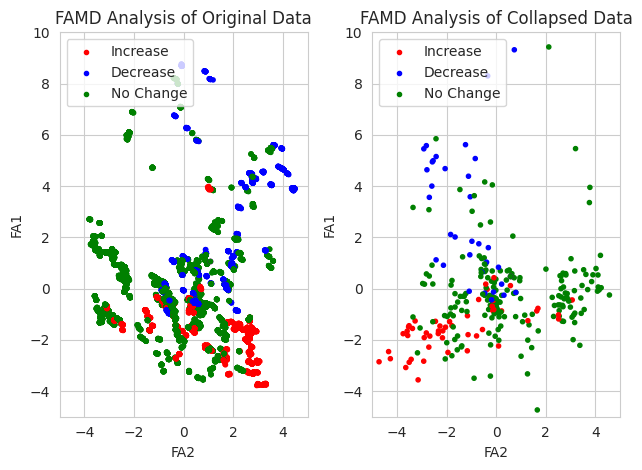

In [124]:
# We now visualize the whole dataset in 2D
plt.subplot(121)
plt.scatter(X_famd[:][1], X_famd[:][0], marker='.', c=y.astype(float), cmap=custom_cmap)
plt.title('FAMD Analysis of Original Data')
plt.xlabel('FA2')
plt.ylabel('FA1')
plt.xlim(-5, 5)
plt.ylim(-5, 10)

plt.scatter(X_famd[0][1], X_famd[0][0], label="Increase", color='r', marker='.')
plt.scatter(X_famd[0][1], X_famd[0][0], label="Decrease", color='b', marker='.')
plt.scatter(X_famd[0][1], X_famd[0][0], label="No Change", color='g', marker='.')
plt.legend(loc='upper left')

plt.subplot(122)
# We now visualize the whole dataset in 2D
plt.scatter(X_famd_beta[:][1], X_famd_beta[:][0], marker='.', c=y_beta.astype(float), cmap=custom_cmap)
plt.title('FAMD Analysis of Collapsed Data')
plt.xlabel('FA2')
plt.ylabel('FA1')
plt.xlim(-5, 5)
plt.ylim(-5, 10)

plt.scatter(X_famd_beta[0][1], X_famd_beta[0][0], label="Increase", color='r', marker='.')
plt.scatter(X_famd_beta[0][1], X_famd_beta[0][0], label="Decrease", color='b', marker='.')
plt.scatter(X_famd_beta[0][1], X_famd_beta[0][0], label="No Change", color='g', marker='.')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [117]:
print("Shape of original data:", df.shape)
print("Shape of collapsed data:", df_beta.shape)

Shape of original data: (12525, 18)
Shape of collapsed data: (274, 32)


The original data has 12,525 data points while the collapsed has 274. 

### Learning Algorithms and In-Depth Analysis

We use random forests and XGBoost for training our models, using the collapsed data and using FAMD to reducethe dimensionality of the data to only 4 principle components. We use grid search to find the best hyperparameters for the models.

In the end, we find that the best model is a random forest with the following hyperparameters:

 {'max_depth': 20,
  'max_features': 'log2',
  'min_samples_leaf': 4,
  'min_samples_split': 5,
  'n_estimators': 50})

  The accuracy matrix for this model is:
                precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.59      0.90      0.71        30
         2.0       0.67      0.30      0.41        20

    accuracy                           0.60        55
   macro avg       0.42      0.40      0.37        55
weighted avg       0.56      0.60      0.54        55

### Ethical Implications

We have attempted to develop a model for predicting changes in the federal funds rate based on available economic indicators. As mentioned previously, the ability to predict changes to this prevailing interest rate before FOMC announcement allows for making strategical decisions to minimize or eliminate losses. For example, a prior prediction of what will happen to interest rates might motivate an individual to move from a low-security job to a high-security job, choose to wait or to rush to get a loan, or sell and buy stocks prior to a big move in the stock market.

Our intent and methodology raise a number of ethical issues. First, attempting to obtain an advantage through  information about the future inherently leads to others who do not share that information facing a disadvantage. For example, someone who has highly credible evidence to believe that the Federal Reserve will decrease the federal funds rate has incentive to sell stocks while keeping this information private so that others do not push the stock price down. Yet by not sharing that evidence, such an individual puts other investors in a more difficult place. Such moral grounds are the basis for material nonpublic information laws that prohibit using, sharing, or selling information about future company decisions that will affect stock prices to turn a profit [5]. While the information obtained through analysis such as that performed in this portfolio is not nearly as certain or exclusive (as the work we have done is highly reproducible), it is still important to acknowledge that successful attempts to predict the market in order to profit will inevitably result in someone losing in a zero-sum, competitive financial world.

Another ethical consideration is the potential loss that could be incurred when too much trust is placed in the prediction of the change in the federal fund rate generated by a model such as ours. With so many factors being weighed and considered by the Federal Reserve, and with economic indicators being so numerous and complex, it is inconceivable that any model used to predict changes in the federal funds rate could have near-perfect accuracy. Those that do not understand the extreme uncertainty involved in both the inputs and outputs to the model are likely to pivot too far, opening themselves up to loss incurred when the actual Federal Reserve decision flies in the face of predictions. In making and sharing predictions, therefore, it is important that equal emphasis and care is placed to express the uncertainty of the outcome, as well as to acknowledge that despite warnings, many will take risks based on the predictions that may have severe economic consequences.

Finally, it is important to note that our aim and methodology of predicting economic outcomes, when implemented and replicated on a large scale, may actually influence the outcomes themselves. Several times throughout history, the mere expectation of economic outcomes or a lack of faith in economic indicators have created economic disasters. For instance, in the events of Black Monday on October 19, 1987, the Dow Jones Industrial Average fell twenty percent in one day. The initial trigger was nervousness about the U.S. trade deficit and the decline of the U.S. dollar, but the crisis was intensified by panic due to a lack of information as to what was happening [6]. This episode and many others demonstrate that expectations or predictions of what will happen, whether grounded or totally unfounded, can often become a self-fulfilling prophecy. Thus it is possible that initially spurious relationships between economic indicators and interest rates mistakenly included or even emphasized in a model like this one might actually generate an unintended (and perhaps undesired) causal relationship, especially when machine learning is involved. Thus care must be taken to critically analyze how features are included, removed, or split on in such models, especially when destructive self-fulfilling feedback loops can have dramatic financial effects on millions across the country.  

### Citations:

[1] “Federal Open Market Committee.” The Fed - Federal Open Market Committee, www.federalreserve.gov/monetarypolicy/fomc.htm.

[2] Chen, James. “Federal Funds Rate: What It Is, How It’s Determined, and Why It’s Important.” Investopedia, Investopedia, www.investopedia.com/terms/f/federalfundsrate.asp.

[3] “Monetary Policy: What Are Its Goals? How Does It Work?” Federal Reserve Board - Monetary Policy: What Are Its Goals? How Does It Work?, www.federalreserve.gov/monetarypolicy/monetary-policy-what-are-its-goals-how-does-it-work.htm.

[4] Gavin, William T, and Rachel J Mandal. “The Art of Predicting the Federal Reserve: St. Louis Fed.” Saint Louis Fed Eagle, Federal Reserve Bank of St. Louis, 9 Dec. 2021, www.stlouisfed.org/publications/regional-economist/july-2000/inside-the-briefcase-the-art-of-predicting-the-federal-reserve.

[5] Chen, James. “Material Nonpublic Information (MNPI)? Definition and Laws.” Investopedia, Investopedia, www.investopedia.com/terms/m/materialinsiderinformation.asp.

[6] Carlson, Mark A. “A brief history of the 1987 stock market crash with a discussion of the Federal Reserve Response.” Finance and Economics Discussion Series, vol. 2006, no. 13, 2006, pp. 1–24, https://doi.org/10.17016/feds.2007.13.